# Data Processing for RSNA Pneumonia Detection Challenge

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydicom
import cv2
import toolkit
from constants import * 

In [15]:
df_test = pd.read_csv('/data/RSNA/stage_1_sample_submission.csv')
df_test["PredictionString"] = ""
df_test.set_index = "patientId"
df_test.to_csv("/data/stage_1_sample_submission_test.csv", index=False)

In [9]:
data = pydicom.read_file("/data/RSNA/train/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm")
img_array = data.pixel_array
img_array.shape

(1024, 1024)

## Load training labels and info

In [2]:
df_train = pd.read_csv(TRAIN_LABELS_CSV, engine="python")
df_train.head(10)
df_train.Target.value_counts()

0    20025
1     8964
Name: Target, dtype: int64

In [5]:
df_train[df_train.Target==1].to_csv("/data/RSNA/train/stage_1_train_labels_pos.csv")

## Count number of training examples in each detailed class

In [8]:
df_train_details = pd.read_csv(CLASS_INFO_CSV, engine="python")
df_train_details['class'].value_counts()

No Lung Opacity / Not Normal    11500
Lung Opacity                     8964
Normal                           8525
Name: class, dtype: int64

## Display sample image

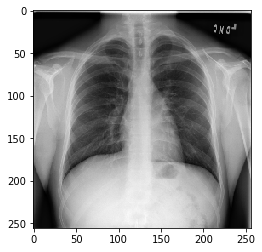

In [11]:
img_array = toolkit.get_image_array(df_train.iloc[3].patientId, IMG_W, IMG_H)

# plot image
plt.imshow(img_array, cmap="gray")

## Merge df_train with df_train detail classes 

In [6]:
df = df_train.merge(df_train_details, left_index=True, right_index=True, how='outer', suffixes=('', '_y'))
df = df[['patientId', 'x', 'y', 'width', 'height', 'Target', 'class']]
df['image'] = df['patientId'].apply(toolkit.get_image_array)

## Load UNet pre-trained with Lungs

In [1]:
from keras.models import load_model
from skimage import exposure
import cv2

im_shape = (IMG_W,IMG_H)
model_name = '../lung-segmentation-2d/trained_model.hdf5'
UNet = load_model(model_name)

Using TensorFlow backend.


NameError: name 'IMG_W' is not defined

## Function to Predict Lung Location

In [5]:
def predict_lung(img_array):
    img_array = (img_array - img_array.mean()) / img_array.std()
    test_x = img_array.reshape([1,256, 256,1])
    img = exposure.rescale_intensity(np.squeeze(test_x), out_range=(0,1))
    pred = UNet.predict(test_x)[..., 0].reshape([1,256, 256,1])
    pred = pred.astype(np.float16)
    return pred

In [20]:
df = pd.read_hdf("/data/RSNA/df_256.h5")
df.head(10)

,patientId,x,y,width,height,Target,class,image
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,"[[92, 50, 30, 17, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4..."
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,"[[20, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,"[[18, 16, 15, 15, 14, 14, 13, 14, 14, 14, 14, ..."
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,"[[205, 202, 193, 192, 187, 185, 180, 179, 177,..."
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,"[[2, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 3, 4, 4, 5,..."
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,Lung Opacity,"[[2, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 3, 4, 4, 5,..."
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,"[[1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2,..."
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,"[[226, 163, 112, 81, 58, 39, 25, 19, 19, 19, 2..."
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1,Lung Opacity,"[[44, 15, 4, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, ..."
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1,Lung Opacity,"[[44, 15, 4, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, ..."


## Make Lung Location Prediction Column

In [6]:
df['lung_location_pred'] = df['image'].apply(predict_lung)

In [9]:
df_loc = df_loc[['patientId','loc']]
df_loc.to_pickle("/data/RSNA/df_loc_256.pkl")

MemoryError: 

In [2]:
df = pd.read_hdf("/data/RSNA/df_256.h5")

In [2]:
df_loc = pd.read_pickle("/data/RSNA/train_df_loc_256.pkl")
df_loc.head(10)

,patientId,lung_location_pred
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,"[[0.0016, 0.0003, 0.0003, 0.0002, 0.0001, 0.00..."
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,00322d4d-1c29-4943-afc9-b6754be640eb,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,"[[0.0023, 0.0002, 0.0001, 0.0, 0.0, 0.0, 0.0, ..."
4,00436515-870c-4b36-a041-de91049b9ab4,"[[0.0002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
5,00436515-870c-4b36-a041-de91049b9ab4,"[[0.0002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
6,00569f44-917d-4c86-a842-81832af98c30,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,"[[0.0003, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
8,00704310-78a8-4b38-8475-49f4573b2dbb,"[[0.0043, 0.0019, 0.0013, 0.0011, 0.0008, 0.00..."
9,00704310-78a8-4b38-8475-49f4573b2dbb,"[[0.0043, 0.0019, 0.0013, 0.0011, 0.0008, 0.00..."


In [3]:
df_seg = pd.read_pickle("/data/RSNA/df_seg_256.pkl")
df_seg.head(10)

,patientId,seg
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,"[[0.147216796875, 0.0149993896484375, 0.008995..."
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,00322d4d-1c29-4943-afc9-b6754be640eb,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,"[[0.471435546875, 0.0404052734375, 0.019302368..."
4,00436515-870c-4b36-a041-de91049b9ab4,"[[0.0004000663757324219, 0.0, 0.0, 0.0, 0.0, 0..."
5,00436515-870c-4b36-a041-de91049b9ab4,"[[0.0004000663757324219, 0.0, 0.0, 0.0, 0.0, 0..."
6,00569f44-917d-4c86-a842-81832af98c30,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,"[[0.06781005859375, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
8,00704310-78a8-4b38-8475-49f4573b2dbb,"[[0.189208984375, 0.02850341796875, 0.00519943..."
9,00704310-78a8-4b38-8475-49f4573b2dbb,"[[0.189208984375, 0.02850341796875, 0.00519943..."


In [4]:
df_loc["lung_location_pred"] = df_loc["lung_location_pred"].apply(lambda x: x.astype(np.double))
loc_128 = df_loc["lung_location_pred"].apply(lambda x: cv2.resize(x, (128,128)))
df_loc["loc"] = loc_128
df_loc = df_loc[['patientId', 'loc']]

In [5]:
seg_128 = df_seg["seg"].apply(lambda x: cv2.resize(x, (128,128)))
df_seg["seg"] = seg_128

In [6]:
df = pd.read_hdf("./train_df_128.h5")
df.head(10)

,patientId,x,y,width,height,Target,class,image
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,"[[41, 8, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3..."
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,"[[6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,"[[17, 14, 14, 14, 14, 13, 13, 13, 13, 13, 13, ..."
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,"[[191, 181, 170, 165, 161, 160, 158, 157, 155,..."
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,"[[3, 3, 3, 2, 2, 3, 5, 5, 6, 7, 8, 9, 9, 10, 1..."
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,Lung Opacity,"[[3, 3, 3, 2, 2, 3, 5, 5, 6, 7, 8, 9, 9, 10, 1..."
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,"[[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3,..."
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,"[[158, 59, 19, 4, 5, 7, 8, 7, 9, 9, 9, 9, 10, ..."
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1,Lung Opacity,"[[27, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2..."
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1,Lung Opacity,"[[27, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2..."


In [7]:
df = df.merge(df_loc, left_index=True, right_index=True, how='outer', suffixes=('', '_l'))
df = df.merge(df_seg, left_index=True, right_index=True, how='outer', suffixes=('', '_s'))
df['seg'] = df['seg'].apply(lambda x: np.round(x, 3))
df['loc'] = df['loc'].apply(lambda x: np.round(x, 3))

In [10]:
seg = df[['patientId','seg']]
seg.to_pickle("/data/RSNA/df_seg_128.pkl")

In [11]:
loc = df[['patientId','loc']]
loc.to_pickle("/data/RSNA/df_loc_128.pkl")

In [29]:
df.to_hdf("/data/RSNA/df_128.h5", key="train")

/opt/miniconda3/lib/python3.6/site-packages/pandas/core/generic.py:1996: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->['patientId', 'class', 'image', 'loc', 'seg']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


MemoryError: 

## Make Segmentation Column

In [43]:
df['segmentation'] = df.apply(lambda x: x['lung_location_pred'] * x['image'], axis=0)

KeyError: ('lung_location_pred', 'occurred at index patientId')

In [ ]:
df['seg'] = df['seg'].apply(lambda x: np.round(x, 3))
df['loc'] = df['loc'].apply(lambda x: np.round(x, 3))

In [1]:
df.head(5)

NameError: name 'df' is not defined

## Save DataFrame to H5 File

In [ ]:
#df["seg"] = df["image"] * df["lung_location_pred"]
df_loc = df_loc[['patientId','loc']]

df_loc.to_hdf("/data/RSNA/df_loc_256.h5", key='train')

In [1]:
df_loc = pd.read_pickle("/data/RSNA/df_pred_256.pkl")
df_loc.head(5)

NameError: name 'pd' is not defined

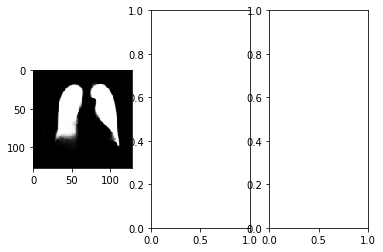

In [11]:
#seg = def_seg.iloc[0]['seg']
fig, axes =  plt.subplots(1,3)
axes[0].imshow(loc_128[0], cmap='gray')
#df.iloc[0]['image'].dtype

In [5]:
from keras.models import load_model
from skimage import exposure
im_shape = (IMG_W,IMG_H)
model_name = '../lung-segmentation-2d/trained_model.hdf5'
UNet = load_model(model_name)

Using TensorFlow backend.
/opt/miniconda3/lib/python3.6/site-packages/keras/engine/saving.py:304: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [41]:
img_array = toolkit.get_image_array(df.iloc[4].patientId, img_width=256, img_height=256)
img_array = (img_array - img_array.mean()) / img_array.std()
test_x = img_array.reshape([1,256, 256,1])
img = exposure.rescale_intensity(np.squeeze(test_x), out_range=(0,1))
pred = UNet.predict(test_x)[..., 0].reshape([1,256, 256,1])


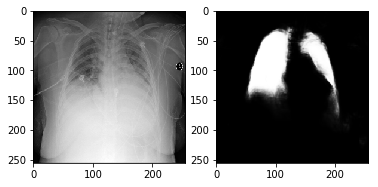

In [42]:
#plt.subplot(1,1)
test_x = test_x.reshape([256,256])
pred = pred.reshape([256,256])
fig, axes =  plt.subplots(1,2)
#ax.imshow(test_x, cmap='gray')

axes[0].imshow(test_x, cmap='gray')
axes[1].imshow(pred, cmap='gray')

In [35]:
pred.shape

(256, 256)

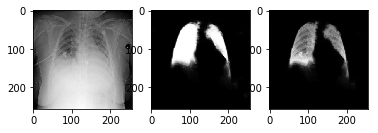

In [32]:
img = df.iloc[4]['image']
pred = df.iloc[4]['lung_location_pred']
pred = pred.reshape([256,256])
seg = img * pred 

fig, axes =  plt.subplots(1,3)
#ax.imshow(test_x, cmap='gray')

axes[0].imshow(img, cmap='gray')
axes[1].imshow(pred, cmap='gray')
axes[2].imshow(seg, cmap='gray')

In [4]:
df_loc["loc"] = df_loc["lung_location_pred"].apply(lambda x: x.reshape([256,256]).astype(float))

In [12]:
df["lung_location_pred"] = df["lung_location_pred"].apply(lambda x: x.round(4)) 

In [33]:
test = df.iloc[0]['lung_location_pred']
df["lung_location_pred"] = df["lung_location_pred"].apply(lambda x: x.reshape([256,256]).astype(np.float16)) 

test.round(4).max()

1.0

In [40]:
df = df[['patientId', 'x', 'y', 'width', 'height', 'Target', 'class', 'image',
       'lung_location_pred']]

In [41]:
df.head(10)

,patientId,x,y,width,height,Target,class,image,lung_location_pred
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,"[[92, 50, 30, 17, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4...","[[0.0016002655029296875, 0.0002999305725097656..."
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,"[[20, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,"[[18, 16, 15, 15, 14, 14, 13, 14, 14, 14, 14, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,"[[205, 202, 193, 192, 187, 185, 180, 179, 177,...","[[0.002300262451171875, 0.00020003318786621094..."
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,"[[2, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 3, 4, 4, 5,...","[[0.00020003318786621094, 0.0, 0.0, 0.0, 0.0, ..."
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,Lung Opacity,"[[2, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 3, 4, 4, 5,...","[[0.00020003318786621094, 0.0, 0.0, 0.0, 0.0, ..."
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,"[[1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,"[[226, 163, 112, 81, 58, 39, 25, 19, 19, 19, 2...","[[0.0002999305725097656, 0.0, 0.0, 0.0, 0.0, 0..."
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1,Lung Opacity,"[[44, 15, 4, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, ...","[[0.004299163818359375, 0.00189971923828125, 0..."
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1,Lung Opacity,"[[44, 15, 4, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, ...","[[0.004299163818359375, 0.00189971923828125, 0..."


In [16]:
submission = pd.read_csv("/home/mschuang/submission.csv")
test_pred = pd.read_csv("./test_class_pred.csv")

In [35]:
submission = submission.merge(test_pred, left_index=True, right_index=True, how='outer', suffixes=('', '_y'))

In [36]:
submission = submission[['patientId','PredictionString','pred_class']]

In [43]:
submission['PredictionString'] = submission.apply(lambda x: x['PredictionString'] if x['pred_class'] == 1 else '', axis=1)

In [45]:
submission.to_csv("submission.csv", index=False)

In [48]:
submission.groupby('pred_class').count()


,patientId,PredictionString
pred_class,,
0,742,742
1,258,229
